## ExMaas & MaaSSim - Pricing Model

## Steps:
    1. Load Nootdord: Network 
    2. Set Demand: 2 travellers and 1 Vehicles
    3. Run ExMaas: Make sure there is a pooling  (inDataSlbts)
    4. Run MaaSSim
    5. Choice set for drivers  - use sblts.rides in prep_shared_rides and not sblts.schedule
    6. Decision 

## Adding paths

In [19]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize the MaaSSim

In [20]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
import logging

## Initialize the ExMAS

In [21]:
import pandas as pd
import ExMAS

## Load the Graph

In [22]:
params = get_config('D:/Development/MaaSSim/data/config/Nootdorp.json')  # load configuration

## Set Demand

In [23]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 4 # 1 hour of simulation
params.nP = 200  # uqests (and passengers)
params.nV = 100  # vehicles

In [24]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 10
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

In [25]:
inData = load_G(inData, params)  # load network graph 

In [26]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

## create shareability graph (ExMAS) 

In [27]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

08-11-22 12:38:12-INFO-Initializing pairwise trip shareability between 200 and 200 trips.
08-11-22 12:38:12-INFO-creating combinations
08-11-22 12:38:12-INFO-39800	 nR*(nR-1)
08-11-22 12:38:13-INFO-Reduction of feasible pairs by 99.77%
08-11-22 12:38:13-INFO-Degree 2 	Completed
08-11-22 12:38:13-INFO-trips to extend at degree 2 : 205
08-11-22 12:38:13-INFO-At degree 2 feasible extensions found out of 10 searched
08-11-22 12:38:13-INFO-Degree 3 	Completed
08-11-22 12:38:13-INFO-trips to extend at degree 3 : 10
08-11-22 12:38:13-INFO-At degree 3 feasible extensions found out of 0 searched
08-11-22 12:38:13-INFO-Degree 4 	Completed
08-11-22 12:38:13-INFO-No more trips to exted at degree 4


## Analyze results

In [28]:
inData.sblts.rides.indexes

0                  [0]
1                  [1]
2                  [2]
3                  [3]
4                  [4]
            ...       
410       [93, 94, 97]
411    [110, 111, 112]
412       [38, 39, 42]
413       [47, 48, 50]
414       [94, 93, 97]
Name: indexes, Length: 415, dtype: object

In [29]:
Results = inData.sblts.rides

In [31]:
Results.loc[(Results.degree!=1)&(Results.degree!=0)]

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
200,"[164, 166]",3.631950,243,20,"[1.4805, 2.1514499999999996]","[11330.0, 80, 35, 128]","[164, 166]","[164, 166]",2.0,200
201,"[68, 71]",7.739200,491,20,"[3.1643499999999998, 4.57485]","[4941.0, 203, 24, 264]","[68, 71]","[68, 71]",2.0,201
202,"[160, 165]",8.541050,584,20,"[5.989374999999999, 2.551675]","[11003.5, 420, 68, 96]","[160, 165]","[160, 165]",2.0,202
203,"[149, 148]",8.226750,327,20,"[4.0642, 4.1625499999999995]","[10562.0, 22, 230, 75]","[149, 148]","[149, 148]",2.0,203
204,"[65, 67]",8.026200,505,20,"[4.43485, 3.5913500000000003]","[4434.0, 287, 34, 184]","[65, 67]","[65, 67]",2.0,204
...,...,...,...,...,...,...,...,...,...,...
410,"[93, 94, 97]",11.868500,430,31,"[4.4289, 5.0806, 2.359]","[6763.0, 26, 38, 130, 138, 98]","[93, 94, 97]","[97, 93, 94]",NaN,410
411,"[110, 111, 112]",10.279325,428,32,"[5.332775, 2.426375, 2.520175]","[8193.5, 129, 38, 150, 41, 70]","[110, 111, 112]","[111, 112, 110]",NaN,411
412,"[38, 39, 42]",13.339375,580,31,"[6.816425, 5.067475, 1.4554749999999999]","[3017.5, 144, 127, 86, 179, 44]","[38, 39, 42]","[42, 39, 38]",NaN,412
413,"[47, 48, 50]",9.103500,389,32,"[4.933249999999999, 2.0027, 2.16755]","[3393.0, 31, 116, 15, 128, 99]","[47, 48, 50]","[48, 50, 47]",NaN,413


In [51]:
Results.degree = Results.apply(lambda row: len(row.indexes), axis=1)
Results

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
0,[0],2.984500,161,1,[2.9844999999999997],"[0, 161]",[0],[0],1,0
1,[1],2.981500,161,1,[2.9815],"[184, 161]",[1],[1],1,1
2,[2],2.307500,124,1,[2.3075],"[307, 124]",[2],[2],1,2
3,[3],1.669500,90,1,[1.6695],"[317, 90]",[3],[3],1,3
4,[4],3.425500,185,1,[3.4255],"[355, 185]",[4],[4],1,4
...,...,...,...,...,...,...,...,...,...,...
410,"[93, 94, 97]",11.868500,430,31,"[4.4289, 5.0806, 2.359]","[6763.0, 26, 38, 130, 138, 98]","[93, 94, 97]","[97, 93, 94]",3,410
411,"[110, 111, 112]",10.279325,428,32,"[5.332775, 2.426375, 2.520175]","[8193.5, 129, 38, 150, 41, 70]","[110, 111, 112]","[111, 112, 110]",3,411
412,"[38, 39, 42]",13.339375,580,31,"[6.816425, 5.067475, 1.4554749999999999]","[3017.5, 144, 127, 86, 179, 44]","[38, 39, 42]","[42, 39, 38]",3,412
413,"[47, 48, 50]",9.103500,389,32,"[4.933249999999999, 2.0027, 2.16755]","[3393.0, 31, 116, 15, 128, 99]","[47, 48, 50]","[48, 50, 47]",3,413


In [52]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,44994696,0,STARTS_DAY,[]
1,3,44994696,0,OPENS_APP,[]
2,3,44994696,21599,ENDS_SHIFT,[]


In [53]:
Results.loc[(Results.degree!=1)&(Results.degree!=0)]

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
200,"[164, 166]",3.631950,243,20,"[1.4805, 2.1514499999999996]","[11330.0, 80, 35, 128]","[164, 166]","[164, 166]",2,200
201,"[68, 71]",7.739200,491,20,"[3.1643499999999998, 4.57485]","[4941.0, 203, 24, 264]","[68, 71]","[68, 71]",2,201
202,"[160, 165]",8.541050,584,20,"[5.989374999999999, 2.551675]","[11003.5, 420, 68, 96]","[160, 165]","[160, 165]",2,202
203,"[149, 148]",8.226750,327,20,"[4.0642, 4.1625499999999995]","[10562.0, 22, 230, 75]","[149, 148]","[149, 148]",2,203
204,"[65, 67]",8.026200,505,20,"[4.43485, 3.5913500000000003]","[4434.0, 287, 34, 184]","[65, 67]","[65, 67]",2,204
...,...,...,...,...,...,...,...,...,...,...
410,"[93, 94, 97]",11.868500,430,31,"[4.4289, 5.0806, 2.359]","[6763.0, 26, 38, 130, 138, 98]","[93, 94, 97]","[97, 93, 94]",3,410
411,"[110, 111, 112]",10.279325,428,32,"[5.332775, 2.426375, 2.520175]","[8193.5, 129, 38, 150, 41, 70]","[110, 111, 112]","[111, 112, 110]",3,411
412,"[38, 39, 42]",13.339375,580,31,"[6.816425, 5.067475, 1.4554749999999999]","[3017.5, 144, 127, 86, 179, 44]","[38, 39, 42]","[42, 39, 38]",3,412
413,"[47, 48, 50]",9.103500,389,32,"[4.933249999999999, 2.0027, 2.16755]","[3393.0, 31, 116, 15, 128, 99]","[47, 48, 50]","[48, 50, 47]",3,413


In [35]:
Results

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
0,[0],2.984500,161,1,[2.9844999999999997],"[0, 161]",[0],[0],1,0
1,[1],2.981500,161,1,[2.9815],"[184, 161]",[1],[1],1,1
2,[2],2.307500,124,1,[2.3075],"[307, 124]",[2],[2],1,2
3,[3],1.669500,90,1,[1.6695],"[317, 90]",[3],[3],1,3
4,[4],3.425500,185,1,[3.4255],"[355, 185]",[4],[4],1,4
...,...,...,...,...,...,...,...,...,...,...
410,"[93, 94, 97]",11.868500,430,31,"[4.4289, 5.0806, 2.359]","[6763.0, 26, 38, 130, 138, 98]","[93, 94, 97]","[97, 93, 94]",3,410
411,"[110, 111, 112]",10.279325,428,32,"[5.332775, 2.426375, 2.520175]","[8193.5, 129, 38, 150, 41, 70]","[110, 111, 112]","[111, 112, 110]",3,411
412,"[38, 39, 42]",13.339375,580,31,"[6.816425, 5.067475, 1.4554749999999999]","[3017.5, 144, 127, 86, 179, 44]","[38, 39, 42]","[42, 39, 38]",3,412
413,"[47, 48, 50]",9.103500,389,32,"[4.933249999999999, 2.0027, 2.16755]","[3393.0, 31, 116, 15, 128, 99]","[47, 48, 50]","[48, 50, 47]",3,413


In [36]:
Results = inData.sblts.rides

In [37]:
Results

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
0,[0],2.984500,161,1,[2.9844999999999997],"[0, 161]",[0],[0],1,0
1,[1],2.981500,161,1,[2.9815],"[184, 161]",[1],[1],1,1
2,[2],2.307500,124,1,[2.3075],"[307, 124]",[2],[2],1,2
3,[3],1.669500,90,1,[1.6695],"[317, 90]",[3],[3],1,3
4,[4],3.425500,185,1,[3.4255],"[355, 185]",[4],[4],1,4
...,...,...,...,...,...,...,...,...,...,...
410,"[93, 94, 97]",11.868500,430,31,"[4.4289, 5.0806, 2.359]","[6763.0, 26, 38, 130, 138, 98]","[93, 94, 97]","[97, 93, 94]",3,410
411,"[110, 111, 112]",10.279325,428,32,"[5.332775, 2.426375, 2.520175]","[8193.5, 129, 38, 150, 41, 70]","[110, 111, 112]","[111, 112, 110]",3,411
412,"[38, 39, 42]",13.339375,580,31,"[6.816425, 5.067475, 1.4554749999999999]","[3017.5, 144, 127, 86, 179, 44]","[38, 39, 42]","[42, 39, 38]",3,412
413,"[47, 48, 50]",9.103500,389,32,"[4.933249999999999, 2.0027, 2.16755]","[3393.0, 31, 116, 15, 128, 99]","[47, 48, 50]","[48, 50, 47]",3,413


In [38]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

08-11-22 12:40:48-INFO-Matching 200 trips to 415 rides in order to min u_pax
08-11-22 12:40:48-INFO-Problem solution: Optimal. 
Total costs for single trips:            564 
reduced by matching to:                  518
08-11-22 12:40:49-WARNING-Setting up 4h simulation at 2022-11-08 10:39:57 for 100 vehicles and 200 passengers in Nootdrop, Netherlands
08-11-22 12:40:53-WARNING-simulation time 3.0 s
08-11-22 12:40:53-WARNING-assertion tests for simulation results - passed


In [42]:
sim.runs[0].rides

,veh,pos,t,event,paxes
0,1,45007127.0,0,STARTS_DAY,[]
1,1,45007127.0,0,OPENS_APP,[]
2,1,45007127.0,0,RECEIVES_REQUEST,[]
3,1,45007127.0,15,ACCEPTS_REQUEST,[]
4,1,45007127.0,35,IS_ACCEPTED_BY_TRAVELLER,[]
...,...,...,...,...,...
5,100,45001819.0,6061,ARRIVES_AT_PICKUP,[]
6,100,45001819.0,6061,MEETS_TRAVELLER_AT_PICKUP,[]
7,100,45001819.0,6091,DEPARTS_FROM_PICKUP,[85]
8,100,552348352.0,6211,ARRIVES_AT_DROPOFF,[85]


In [43]:
sim.runs[0].trips

,pax,pos,t,event,veh_id
0,0,44979753,0,STARTS_DAY,NaN
1,0,44979753,0,REQUESTS_RIDE,NaN
2,0,44979753,0,RECEIVES_OFFER,NaN
3,0,44979753,15,ACCEPTS_OFFER,NaN
4,0,44979753,35,ARRIVES_AT_PICKUP,1.0
...,...,...,...,...,...
5,199,411761806,14086,MEETS_DRIVER_AT_PICKUP,91.0
6,199,411761806,14116,DEPARTS_FROM_PICKUP,91.0
7,199,44985353,14375,ARRIVES_AT_DROPOFF,91.0
8,199,44985353,14385,SETS_OFF_FOR_DEST,NaN


<AxesSubplot:>

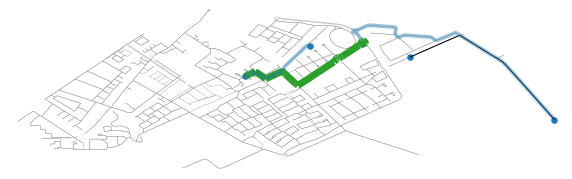

In [45]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

In [46]:
sim.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
id,,,,,,,,,,,,,,,
1,0,44979753,44987282,2022-11-08 10:39:57,NaN,0 days 00:26:54,2022-11-08 11:06:51,NaN,True,NaN,1614,0,0,0,node time req_id od 0 NaN...
2,1,45025769,45007975,2022-11-08 10:43:01,NaN,0 days 00:26:52,2022-11-08 11:09:53,NaN,True,NaN,1612,0,243,0,node time req_id od 0 NaN...
3,2,44974670,44978600,2022-11-08 10:45:04,NaN,0 days 00:20:49,2022-11-08 11:05:53,NaN,True,NaN,1249,0,2,0,node time req_id od 0 NaN...
4,4,522125185,44990922,2022-11-08 10:45:52,NaN,0 days 00:30:52,2022-11-08 11:16:44,NaN,True,NaN,1852,0,4,0,node time req_id od 0 N...
5,5,1903129102,45006066,2022-11-08 10:46:57,NaN,0 days 00:21:28,2022-11-08 11:08:25,NaN,True,NaN,1288,0,5,0,node time req_id od 0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,194,45023685,45020953,2022-11-08 14:30:03,NaN,0 days 00:02:12,2022-11-08 14:32:15,NaN,True,NaN,132,0,194,0,node time req_id od 0 NaN...
139,196,1658828036,44992305,2022-11-08 14:31:34,NaN,0 days 00:14:27,2022-11-08 14:46:01,NaN,True,NaN,867,0,196,0,node time req_id od 0 ...
140,197,4290089188,515740406,2022-11-08 14:33:54,NaN,0 days 00:26:47,2022-11-08 15:00:41,NaN,True,NaN,1607,0,197,0,node time req_id od 0 ...


## TrevelAgent

In [47]:
self = sim.pax[0]

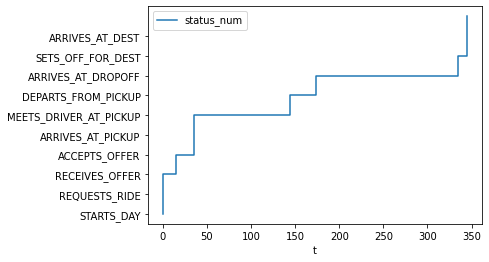

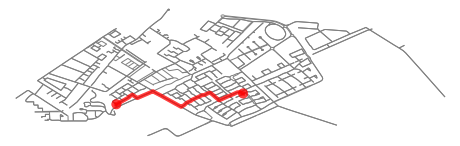

<AxesSubplot:xlabel='t'>

In [48]:
from MaaSSim.visualizations import plot_trip
plot_trip(sim, self.id)

## VehicleAgent

In [49]:
self = sim.vehs[2]

<AxesSubplot:>

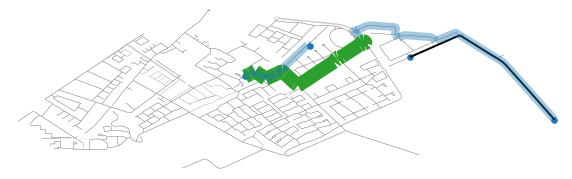

In [50]:
from MaaSSim.visualizations import plot_veh_sim
plot_veh_sim(sim, self.id)